In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# read and parse data
df = pd.read_csv('labels_and_ids.csv')
df = df.set_index('id')
for idx, i in df['inbound_event_ids'].items():
    cleaned_value = i.replace('[', '').replace(']', '').split(',')[0]
    df.at[idx, 'inbound_event_ids'] = cleaned_value

In [11]:
# group data by jericho_human_classification
grouped = df.groupby(['jericho_human_classification'])['inbound_event_ids'].apply(list)
ham_list = grouped['ham']
spam_list = grouped['spam']
phish_list = grouped['phish']
ham_list = sorted([int(i) for i in ham_list])
spam_list = sorted([int(i) for i in spam_list])
phish_list = sorted([int(i) for i in phish_list])
print(len(ham_list), len(spam_list), len(phish_list))
# get first 500 ids in each category
print(ham_list[:500])
print(spam_list[:500])

590 539 22
[156, 160, 226, 229, 261, 317, 325, 333, 338, 404, 414, 423, 436, 450, 452, 471, 490, 508, 510, 511, 517, 545, 546, 549, 578, 581, 588, 601, 603, 610, 641, 645, 653, 657, 671, 690, 710, 728, 836, 862, 863, 898, 912, 922, 953, 994, 1066, 1074, 1089, 1093, 1158, 1171, 1229, 1250, 1293, 1301, 1309, 1330, 1339, 1350, 1395, 1402, 1418, 1463, 1491, 1549, 1550, 1575, 1582, 1622, 1624, 1626, 1636, 1647, 1648, 1653, 1719, 1725, 1785, 1800, 1826, 1831, 1906, 1917, 1919, 1932, 1937, 2015, 2035, 2055, 2074, 2081, 2090, 2100, 2119, 2164, 2172, 2223, 2238, 2253, 2303, 2373, 2388, 2404, 2472, 2488, 2499, 2519, 2558, 2577, 2659, 2683, 2693, 2696, 2727, 2730, 2733, 2764, 2784, 2823, 2825, 2838, 2842, 2858, 2862, 2910, 2943, 2955, 2977, 3000, 3026, 3057, 3067, 3069, 3889, 3900, 3910, 3911, 3974, 3982, 3996, 4014, 4015, 4053, 4058, 4072, 4089, 4152, 4166, 4194, 4197, 4224, 4236, 4368, 4450, 4543, 4553, 4605, 4668, 4675, 4769, 4854, 4916, 4931, 4962, 4968, 4992, 4993, 5016, 5032, 5041, 5061, 50

The list of spam and ham are used to extract relevant entries from the heroku database as training data.

In [12]:
ham_test = ham_list[500:]
ham_test = np.column_stack((['ham'] * len(ham_test), ham_test))
spam_test = spam_list[500:]
spam_test = np.column_stack((['spam'] * len(spam_test), spam_test))
test_df = pd.DataFrame(np.concatenate((ham_test, spam_test), axis=0), columns=['jericho_human_classification', 'id'])
test_data_df = pd.read_csv('inbound_test.csv')
merged_test_df = pd.concat([test_df, test_data_df], axis=1)
merged_test_df.head()

,jericho_human_classification,id,id,category,from,processed_body,processed_subject
0,ham,11984,11984,bcc_email_sec_inbound,noreply@notifications.hubspot.com,Your Campaigns export &quot;Campaigns Reportin...,"Your Campaigns export ""Campaigns Reporting Exp..."
1,ham,11988,11988,bcc_email_sec_inbound,noreply@notifications.hubspot.com,Your export &quot;Manu_Project_Knowbe4_21-05-...,"Your export ""Manu_Project_Knowbe4_21-05-2024 ..."
2,ham,11989,11989,bcc_email_sec_inbound,noreply@notifications.hubspot.com,Your export &quot;Lead2Pipeline Static List &...,"Your export ""Lead2Pipeline Static List (Campa..."
3,ham,11997,11997,bcc_email_sec_inbound,noreply@notifications.hubspot.com,Your export &quot;Manu_Project_Knowbe4_21-05-...,"Your export ""Manu_Project_Knowbe4_21-05-2024 ..."
4,ham,12000,12000,bcc_email_sec_inbound,noreply@notifications.hubspot.com,Your export &quot;Manu_Project_Knowbe4_21-05-...,"Your export ""Manu_Project_Knowbe4_21-05-2024 ..."


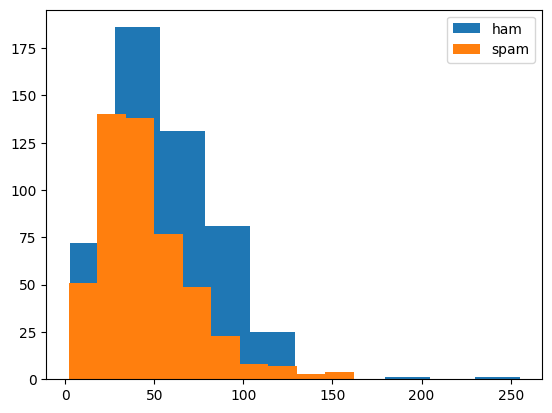

In [13]:
ham_data = pd.read_csv('labelled_ham.csv')
spam_data = pd.read_csv('labelled_spam.csv')
ham_subject_len = ham_data['processed_subject'].apply(len)
spam_subject_len = spam_data['processed_subject'].apply(len)
np.histogram(ham_subject_len, bins=10)
np.histogram(spam_subject_len, bins=10)
plt.hist(ham_subject_len, bins=10)
plt.hist(spam_subject_len, bins=10)
# add legend
plt.legend(['ham', 'spam'])

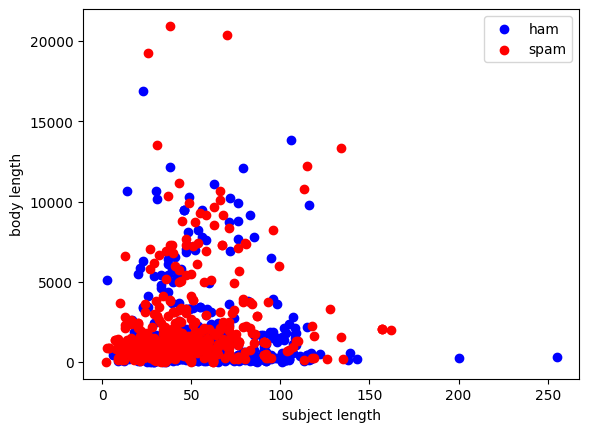

In [14]:
# train on ham and spam data
ham_data['jericho_human_classification'] = 'ham'
spam_data['jericho_human_classification'] = 'spam'
plt.scatter(ham_data['processed_subject'].apply(len), ham_data['processed_body'].apply(len), c='blue')
plt.scatter(spam_data['processed_subject'].apply(len), spam_data['processed_body'].apply(len), c='red')
plt.xlabel('subject length')
plt.ylabel('body length')
plt.legend(['ham', 'spam'])


In [15]:
from sklearn import tree
merged_data = pd.concat([ham_data, spam_data], axis=0)
training_data = pd.DataFrame()
training_data['jericho_human_classification'] = merged_data['jericho_human_classification'].apply(lambda x: 1 if x == 'ham' else 0)
training_data['processed_body'] = merged_data['processed_body'].apply(len)
training_data['processed_subject'] = merged_data['processed_subject'].apply(len)
X = training_data[['processed_subject', 'processed_body']]
Y = training_data['jericho_human_classification']
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [18]:
parsed_merged_test = pd.DataFrame()
parsed_merged_test['processed_body'] = merged_test_df['processed_body'].apply(len)
parsed_merged_test['processed_subject'] = merged_test_df['processed_subject'].apply(len)
test_result = clf.predict(parsed_merged_test[['processed_subject', 'processed_body']])
test_result = pd.DataFrame(test_result, columns=['test_classification'])
test_result.head()


,test_classification
0,1
1,1
2,1
3,1
4,1


In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(merged_test_df['jericho_human_classification'].apply(lambda x: 1 if x == 'ham' else 0), test_result['test_classification'])
accuracy = (cf[0][0] + cf[1][1]) / np.sum(cf)
precision = cf[0][0] / (cf[0][0] + cf[1][0])
print("accuracy: ", accuracy)
print("precision: ", precision)


accuracy:  0.6046511627906976
precision:  0.39285714285714285
